In [1]:
library(Seurat)
library(Matrix)
library(dplyr)
library(tibble)
library(ggplot2)
inputdir <- "./load_files/"
outputdir <- "./report/"
source("./ptime.fun.v2.R")


Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


circlize version 0.4.13
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))


Loading required package: grid

ComplexHeatmap version 2.2.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it i

In [2]:
##------------------------------------------------------------------------------------------
## Correlation of gene expression with pseudotime
load(file = paste0("../region_differences/load_files/", "Pseudobulk_by_region_tRG_oRG.Rdata")) 
## avgs, pmeta, rgc_cbn, 
avgs <- as.matrix(avgs)
all_regs <- c("FC", "MSC", "TC", "OcC")


## Subset the pmeta data
meta_sub <- pmeta[pmeta$lineage == "shared" & pmeta$lobe %in% c("FC", "MSC", "OcC"), ]
avg_sub <- avgs[, meta_sub$avgcls]
head(meta_sub)

,avgcls,lineage,lobe,bin,lin_bin,pseudotime,cluster
,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>
shared|FC|6,shared|FC|6,shared,FC,6,shared|6,2.979209,vRG HMGA2 CCND1
shared|FC|7,shared|FC|7,shared,FC,7,shared|7,3.488414,vRG HMGA2 CCND1
shared|FC|5,shared|FC|5,shared,FC,5,shared|5,2.502953,vRG HMGA2 CCND1
shared|FC|11,shared|FC|11,shared,FC,11,shared|11,5.502376,vRG HMGA2 CCND1
shared|FC|9,shared|FC|9,shared,FC,9,shared|9,4.478030,vRG HMGA2 CCND1
shared|FC|8,shared|FC|8,shared,FC,8,shared|8,4.002993,vRG HMGA2 CCND1


In [3]:
## Use only DEGs
load(file = paste0("../region_differences/load_files/", "Region_DEGs_res_v2.rds")) ## vrg_deg, org_deg
genes <- unlist(vrg_deg) %>% union(., unlist(org_deg)) %>% unique()
psval <- 0.1

pdata <- lapply(c("FC", "MSC", "OcC"), function(reg) {
    reg_meta <- meta_sub[meta_sub$lobe == reg, ]
    res <- cor(t(avg_sub[genes, reg_meta$avgcls, drop = FALSE]), reg_meta$pseudotime, method = "s")
    simi <- setNames(res[, 1], rownames(res))
    simi[is.na(simi)] <- 0
    
    ## In case gene expression is too small
    simi[apply(avg_sub[genes, reg_meta$avgcls, drop = FALSE], 1, max) < 0.5] <- 0
    return(simi)
    }) %>%
    setNames(., c("FC", "MSC", "OcC")) %>%
    as.data.frame() %>%
    mutate(gene = genes) %>%
    mutate(label = ifelse(abs(OcC) >= 0.55 & abs(FC) >= 0.55 & FC*OcC < 0, gene, NA)) %>%
    mutate(color = ifelse(is.na(label), "lightgrey", "red")) %>%
    mutate(size = ifelse(is.na(label), 1.5, 3.5))
head(pdata)

Warning message in cor(t(avg_sub[genes, reg_meta$avgcls, drop = FALSE]), reg_meta$pseudotime, :
“the standard deviation is zero”
Warning message in cor(t(avg_sub[genes, reg_meta$avgcls, drop = FALSE]), reg_meta$pseudotime, :
“the standard deviation is zero”


,FC,MSC,OcC,gene,label,color,size
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
PTN,0.9360165,1.0000000,0.9979360,PTN,NA,lightgrey,1.5
NNAT,-0.9876161,-0.9500000,-0.1310630,NNAT,NA,lightgrey,1.5
RBP1,-0.8926729,-0.6147059,0.0000000,RBP1,NA,lightgrey,1.5
LOC106993104,0.9834881,0.9882353,0.9711042,LOC106993104,NA,lightgrey,1.5
DCT,-0.3663571,0.0000000,0.0000000,DCT,NA,lightgrey,1.5
COL2A1,-0.9504644,-0.5705882,0.0000000,COL2A1,NA,lightgrey,1.5


Warning message:
“Removed 543 rows containing missing values (geom_text_repel).”


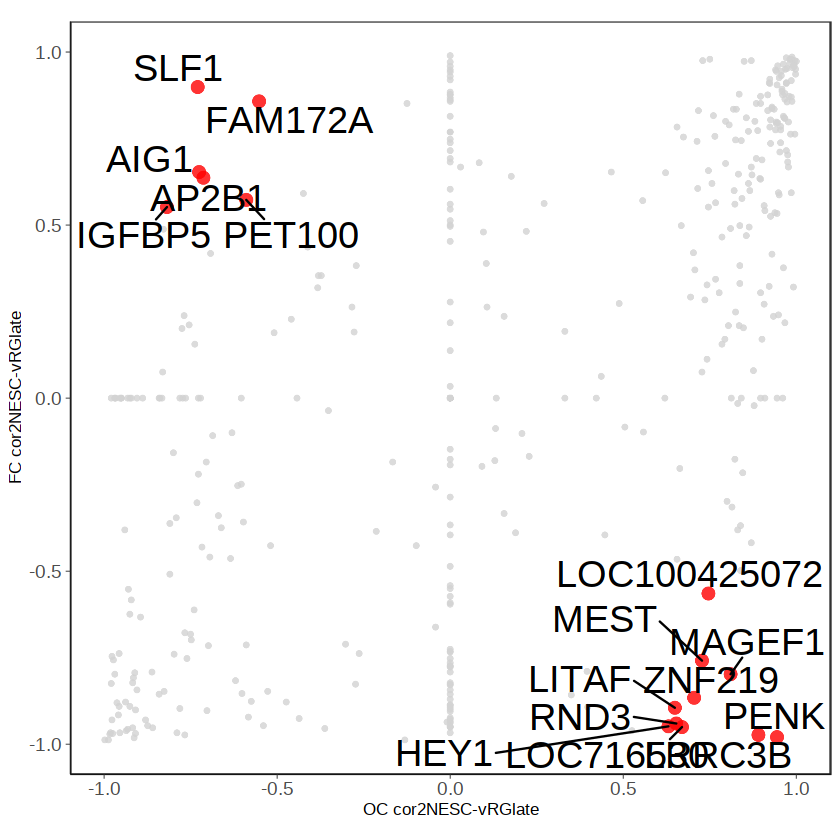

In [4]:
p <- ggplot(pdata, aes_string(x = "OcC", y = "FC", label = "label", color = "color", size = "size")) + 
            ggrastr::rasterise(geom_point(shape = 16, alpha = 0.8), dpi = 300) + 
            ggrepel::geom_text_repel(size = 8, color = "black", seed = 42) +
            theme_bw() + 
            scale_size_identity() + 
            scale_color_identity() +
            labs(y = "FC cor2NESC-vRGlate", x = "OC cor2NESC-vRGlate") +
            coord_fixed() + 
            theme(panel.grid.minor = element_blank(),
                panel.grid.major = element_blank(),
                axis.title = element_text(size = rel(0.9)), 
                axis.text = element_text(size = rel(1)), 
                axis.line = element_line(size = 0.2), 
                axis.ticks = element_line(size = 0.2), 
                legend.position = "right")
p

In [5]:
pdf(paste0(outputdir, "Diff_Temporal_dynamics_dotplot.pdf"), width = 6, height = 6, useDingbats = FALSE)
print(p)
dev.off()

Warning message:
“Removed 543 rows containing missing values (geom_text_repel).”


png 
  2

In [6]:
##------------------------------------------------------------------------------------------
## Plot the expression dynamics
load(file = paste0("../region_differences/load_files/", "Pseudobulk_by_region_tRG_oRG.Rdata")) #avgs, pmeta


meta_sub <- pmeta[pmeta$lineage == "shared", ]
avg_sub <- avgs[, meta_sub$avgcls] %>%
            t() %>% scale() %>% t() %>%
            MinMax(., min =  -1.5, max = 2)
head(meta_sub)

,avgcls,lineage,lobe,bin,lin_bin,pseudotime,cluster
,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>
shared|FC|6,shared|FC|6,shared,FC,6,shared|6,2.979209,vRG HMGA2 CCND1
shared|FC|7,shared|FC|7,shared,FC,7,shared|7,3.488414,vRG HMGA2 CCND1
shared|FC|5,shared|FC|5,shared,FC,5,shared|5,2.502953,vRG HMGA2 CCND1
shared|FC|11,shared|FC|11,shared,FC,11,shared|11,5.502376,vRG HMGA2 CCND1
shared|FC|9,shared|FC|9,shared,FC,9,shared|9,4.478030,vRG HMGA2 CCND1
shared|FC|8,shared|FC|8,shared,FC,8,shared|8,4.002993,vRG HMGA2 CCND1


Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(features)` instead of `features` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.

Warning message:
“Ignoring unknown parameters: interpolate”
`geom_smooth()` using formula 'y ~ x'



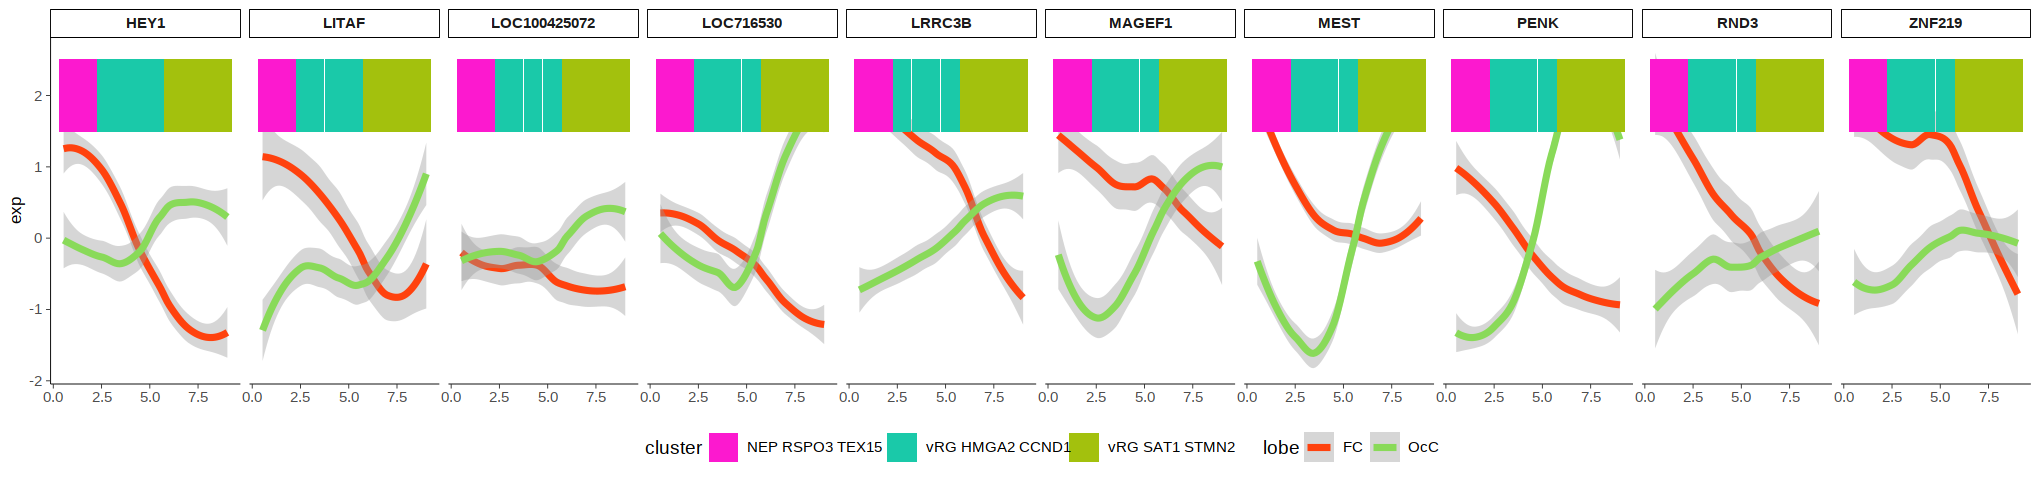

In [7]:
gset1 <- pdata$gene[(!is.na(pdata$label)) & pdata$OcC >= 0.55]
p1 <- plot_region_line(meta = meta_sub, data = avg_sub, features = gset1, 
                 reg_col = "lobe", pseudotime_col = "pseudotime", 
                 file_name = "Diff_Temporal_dynamics_Line_PENK.pdf", 
                 output_dir = outputdir, reg_order = c("FC", "OcC"), 
                 return.plot = TRUE, plot.scale = 1, ncol = 4)
options(repr.plot.width=17, repr.plot.height=4)
p1

Warning message:
“Ignoring unknown parameters: interpolate”
`geom_smooth()` using formula 'y ~ x'



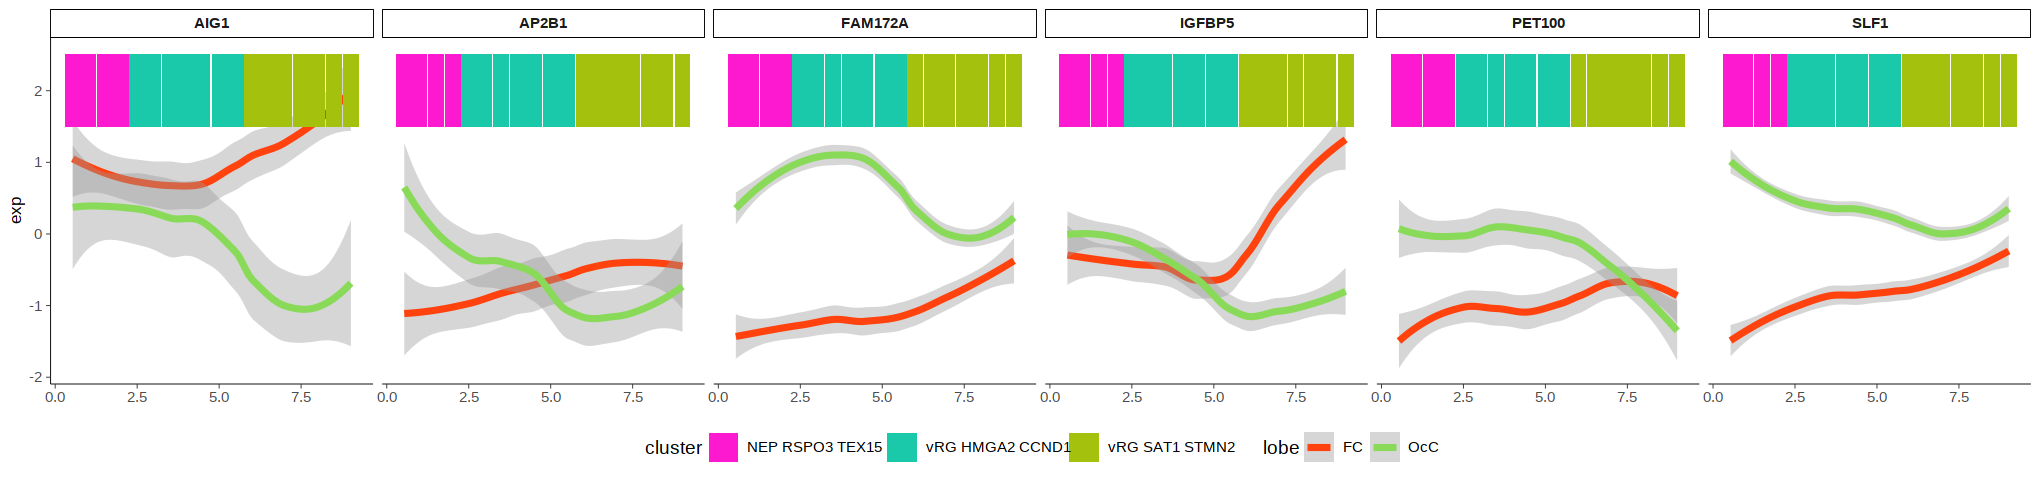

In [8]:
gset2 <- pdata$gene[(!is.na(pdata$label)) & pdata$FC >= 0.55]
p2 <- plot_region_line(meta = meta_sub, data = avg_sub, features = gset2, 
                       reg_col = "lobe", pseudotime_col = "pseudotime", 
                       file_name = "Diff_Temporal_dynamics_Line_IGFBP5.pdf", 
                       output_dir = outputdir, reg_order = c("FC", "OcC"), 
                       return.plot = TRUE, plot.scale = 1, ncol = 4)
options(repr.plot.width=17, repr.plot.height=4)
p2

In [9]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS:   /gpfs/ycga/home/sm2726/packages/R_versions/R-3.6.1/lib64/R/lib/libRblas.so
LAPACK: /gpfs/ycga/home/sm2726/packages/R_versions/R-3.6.1/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] tidyr_1.1.3          ggforce_0.3.1        scatterpie_0.1.5    
 [4] ComplexHeatmap_2.2.0 circlize_0.4.13      URD_1.1.0           
 [7] ggplot2_3.3.0        tibble_3.0.1   